<a href="https://colab.research.google.com/github/fabianfallasmoya/agro/blob/master/Eval_ODMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!pip install pycocotools numpy==1.16.0 opencv-python tqdm tensorboard tensorboardX pyyaml webcolors matplotlib
!pip install torch==1.4.0
!pip install torchvision==0.5.0

### Prepare the required repositories
* https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch

* https://github.com/rafaelpadilla/Object-Detection-Metrics

In [24]:
import os
import sys
import shutil
#Download EfficientDet
if "Yet-Another-EfficientDet-Pytorch" not in os.getcwd():
  !git clone --depth 1 https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch
else:
  !git pull

#Download Object Detection Metrics
if "Object-Detection-Metrics" not in os.getcwd():
  !git clone --depth 1 https://github.com/rafaelpadilla/Object-Detection-Metrics
else:
  !git pull


fatal: destination path 'Yet-Another-EfficientDet-Pytorch' already exists and is not an empty directory.
fatal: destination path 'Object-Detection-Metrics' already exists and is not an empty directory.


# Executing the Object Detection Metrics, through Rafael's Padilla code

### The next cell will be the only one to be changed

In [57]:
###These lines need to be changed by the user################

project = 'apple' #This is the yml project name, also is the class name of the bboxes
weightsDir = '/content/drive/My Drive/checkpoints/apple/apple/' #This is the directory where the weights file is located
wieghtsFileName = 'efficientdet-d6_epoch60_step3111.pth' #The name of the weights file
#The .zip file of the dataset, this dataset is required with the Zylo structure for efficientDet custom datasets
datasetpath = '/content/drive/My Drive/pineapple_research/deepFruits_dataset/cocoFormat/apple.zip'
#This directory is where the results of the evaluation will be stored
dirForGroundTruthAndDetections = '/content/eval'
nms_threshold = 0.4
coefficient = 6 ## EfficientDet coefficient
###########################################################

## Building the groundtruth and detection files

In [26]:
#CREATE yml for project's config
with open("/content/Yet-Another-EfficientDet-Pytorch/projects/"+str(project)+".yml", "w+") as out:
    out.write("project_name: "+str(project)+"\n")
    out.write("train_set: train\n")
    out.write("val_set: test\n")
    out.write("num_gpus: 1\n")
    out.write("mean: [0.485, 0.456, 0.406]\n")
    out.write("std: [0.229, 0.224, 0.225]\n")
    out.write("anchors_scales: '[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]'\n")
    out.write("anchors_ratios: '[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]'\n")
    out.write("obj_list: ['"+str(project)+"']\n")
    out.write("\n")
    out.write("\n")

In [27]:
weightspath = weightsDir+wieghtsFileName 
! mkdir '/content/Yet-Another-EfficientDet-Pytorch/logs'
! mkdir '/content/Yet-Another-EfficientDet-Pytorch/logs/{project}'
! cp -r '{weightspath}' '/content/Yet-Another-EfficientDet-Pytorch/logs/{project}/'

! mkdir '/content/Yet-Another-EfficientDet-Pytorch/datasets'
! unzip '{datasetpath}' -d '/content/Yet-Another-EfficientDet-Pytorch/datasets/'

mkdir: cannot create directory ‘/content/Yet-Another-EfficientDet-Pytorch/logs’: File exists
mkdir: cannot create directory ‘/content/Yet-Another-EfficientDet-Pytorch/logs/apple’: File exists
mkdir: cannot create directory ‘/content/Yet-Another-EfficientDet-Pytorch/datasets’: File exists
Archive:  /content/drive/My Drive/pineapple_research/deepFruits_dataset/cocoFormat/apple.zip
replace /content/Yet-Another-EfficientDet-Pytorch/datasets/apple/annotations/instances_test.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Yet-Another-EfficientDet-Pytorch/datasets/apple/annotations/instances_test.json  
  inflating: /content/Yet-Another-EfficientDet-Pytorch/datasets/apple/annotations/instances_train.json  
  inflating: /content/Yet-Another-EfficientDet-Pytorch/datasets/apple/test/1237_png.rf.b84f9ebc5046e7c0746f8c8098d84529.jpg  
  inflating: /content/Yet-Another-EfficientDet-Pytorch/datasets/apple/test/Apple_Tree-106_png.rf.64b48008a499effd3c4834c246a55de3.jpg  
  inflati

In [58]:
os.chdir('/content/')
os.chdir('Yet-Another-EfficientDet-Pytorch')
import cv2
import torch
import os
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import matplotlib.pyplot as plt

import numpy as np
import yaml
import json

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess

def getImageDetections(imagePath,weights,nms_threshold,confidenceParam,coefficient):
  compound_coef = coefficient
  force_input_size = None  # set None to use default size
  img_path  = imagePath

  threshold = confidenceParam
  iou_threshold = nms_threshold

  use_cuda = True
  use_float16 = False
  cudnn.fastest = True
  cudnn.benchmark = True

  obj_list = ['pineapple']

  # tf bilinear interpolation is different from any other's, just make do
  input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
  input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
  ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

  if use_cuda:
      x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
  else:
      x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

  x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

  model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                              # replace this part with your project's anchor config
                              ratios=[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)],
                              scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

  model.load_state_dict(torch.load('/content/Yet-Another-EfficientDet-Pytorch/logs/apple/'+weights))
  model.requires_grad_(False)
  model.eval()

  if use_cuda:
      model = model.cuda()
  if use_float16:
      model = model.half()

  with torch.no_grad():
      features, regression, classification, anchors = model(x)

      regressBoxes = BBoxTransform()
      clipBoxes = ClipBoxes()

      out = postprocess(x,
                        anchors, regression, classification,
                        regressBoxes, clipBoxes,
                        threshold, iou_threshold)

  out = invert_affine(framed_metas, out)

  from PIL import Image
  import PIL
      
  for i in range(len(ori_imgs)):
      if len(out[i]['rois']) == 0:
          continue
      detectionsList = []
      for j in range(len(out[i]['rois'])):
          (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
          detectionsList.append((float(out[i]['scores'][j]),x1, y1, x2, y2))
      return detectionsList
os.chdir('/content/')

In [29]:
! mkdir '{dirForGroundTruthAndDetections}/{project}'
! mkdir '{dirForGroundTruthAndDetections}/{project}/groundtruths'
! mkdir '{dirForGroundTruthAndDetections}/{project}/detections'
! mkdir '{dirForGroundTruthAndDetections}/{project}/results'

mkdir: cannot create directory ‘/content/eval/apple’: File exists
mkdir: cannot create directory ‘/content/eval/apple/groundtruths’: File exists
mkdir: cannot create directory ‘/content/eval/apple/detections’: File exists
mkdir: cannot create directory ‘/content/eval/apple/results’: File exists


In [59]:
import json
import pandas as pd
def generateFiles(confidenceParam):
  params = yaml.safe_load(open(f'/content/Yet-Another-EfficientDet-Pytorch/projects/{project}'+'.yml'))
  evaluationfolder = params['val_set']
  ##### Let´s create the Ground Truth files to evaluate them with the Object Detection Metrics
  dirGroundTruthPath = dirForGroundTruthAndDetections+'/'+project+'/groundtruths/'
  dirDetectionsPath = dirForGroundTruthAndDetections+'/'+project+'/detections/'
  with open('/content/Yet-Another-EfficientDet-Pytorch/datasets/apple/annotations/instances_'+str(evaluationfolder)+'.json') as f:
    data = json.load(f)

  annotationsDataframe = pd.DataFrame.from_records(data['annotations'])
  imagesDataframe = pd.DataFrame.from_records(data['images'])

  qtyGroundTruthDets = 0
  qtyPredictedDets = 0
  for index,image in imagesDataframe.iterrows():
    imageName = image['file_name'][0:len(image['file_name'])-4]

    fileGroundTruth = open(dirGroundTruthPath+imageName+".txt","w")
    fileDetections = open(dirDetectionsPath+imageName+".txt","w")

    imageId = image['id']
    for ind,row in annotationsDataframe.loc[annotationsDataframe['image_id'] == imageId].iterrows():
      left = int(row['bbox'][0]) 
      top = int(row['bbox'][1])
      w = int(row['bbox'][2])
      h = int(row['bbox'][3])
      right = left + w
      bottom = top + h
      #<class_name> <left> <top> <right> <bottom>

      fileGroundTruth.write(project+" "+str(left)+" "+str(top)+" "+str(right)+" "+str(bottom)+"\n")
      qtyGroundTruthDets = qtyGroundTruthDets + 1
    
    fileGroundTruth.close()

    ##### Let´s create the detections files to evaluate them with the Object Detection Metrics
    
    defaultDatasetPath = '/content/Yet-Another-EfficientDet-Pytorch/datasets/'+project+'/'+evaluationfolder+'/'
    image_detections = getImageDetections(defaultDatasetPath+image['file_name'],wieghtsFileName,nms_threshold,confidenceParam,coefficient)
    for confidenceScore,xd1,yd1,xd2,yd2 in image_detections:
      fileDetections.write(project+" "+str(confidenceScore)+" "+str(xd1)+" "+str(yd1)+" "+str(xd2)+" "+str(yd2)+"\n")
      qtyPredictedDets = qtyPredictedDets + 1
    fileDetections.close()
  return (qtyGroundTruthDets,qtyPredictedDets)  

## Methods to run the evaluation over the model

In [72]:
def generateResults():
  ! python /content/Object-Detection-Metrics/pascalvoc.py -gt {dirForGroundTruthAndDetections}/{project}/groundtruths/ -det {dirForGroundTruthAndDetections}/{project}/detections/ -t {nms_threshold} -gtformat xyrb -detformat xyrb -sp {dirForGroundTruthAndDetections}/{project}/results

def collectRsultsFromFiles(): 
  with open(dirForGroundTruthAndDetections+'/'+project+'/results/results.txt',"r") as file1:
          FileasList = file1.readlines()

  precision = FileasList[8].split()[len(FileasList[8].split())-1]
  recall = FileasList[9].split()[len(FileasList[9].split())-1]
  precision = float(precision[1:len(precision)-2])
  recall = float(recall[1:len(recall)-2])
  f1Score = 2*((precision*recall)/(precision+recall))
  
  return (FileasList[6].split()[1],FileasList[7].split()[1],precision,recall,f1Score)

## Showing the results

### Showing results with a single confidence score

Folder /content/eval/apple/results already exists and may contain important results.

Enter 'Y' to continue. WARNING: THIS WILL REMOVE ALL THE CONTENTS OF THE FOLDER!
Or enter 'N' to abort and choose another folder to save the results.
y
<Figure size 640x480 with 1 Axes>
AP: 84.76% (apple)
mAP: 84.76%
##############################################
Result over the dataset: apple
Quantity of ground truth boundig boxes: 65
Quantity of predicted boundig boxes: 67
The average precision is (AP): 84.76%
Precision: 0.87
Recall: 0.89
F1 Score: 0.8798863636363636


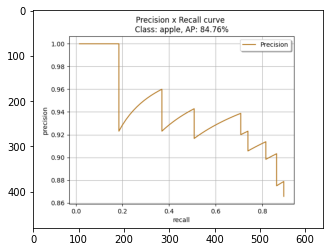

In [73]:
groundTruth, detected = generateFiles(0.5)
generateResults()

dataset,ap,precision,recall,f1Score = collectRsultsFromFiles()
print('##############################################')
print('Result over the dataset: '+ dataset)
print('Quantity of ground truth boundig boxes: '+str(groundTruth))
print('Quantity of predicted boundig boxes: '+str(detected))
print('The average precision is (AP): '+ap)
print('Precision: '+str(precision))
print('Recall: '+str(recall))
print('F1 Score: '+str(f1Score))
prcurveImg = cv2.imread(dirForGroundTruthAndDetections+'/'+project+'/results/'+project+'.png')
plt.imshow(prcurveImg)
plt.show()

### Showing results with a multiple confidence score

In [77]:
confidence_threshold = 0.05
hop = 0.05
import csv
with open(f'{dirForGroundTruthAndDetections}/{project}/{project}_results_d{coefficient}.csv', "w") as myfile:
      my_writer = csv.writer(myfile, delimiter=',', quotechar='"')
      my_writer.writerow(["num_detections", "nms_threshold", "confidence_threshold", "average_precision", "precision", "recall", "f1_score"])

while confidence_threshold < 1:
  ! rm -r {dirForGroundTruthAndDetections}/{project}/results
  ! mkdir '{dirForGroundTruthAndDetections}/{project}/results'
  groundTruth, detected = generateFiles(confidence_threshold)
  generateResults()
  dataset,ap,precision,recall,f1Score = collectRsultsFromFiles()
  
  ##Aqui hay que guar los valores en el CSV
  with open(f'{dirForGroundTruthAndDetections}/{project}/{project}_results_d{coefficient}.csv', "a") as myfile:
            my_writer = csv.writer(myfile, delimiter=',', quotechar='"')
            my_writer.writerow([detected, nms_threshold, confidence_threshold,ap, precision,recall,f1Score])

  confidence_threshold = round(confidence_threshold + hop,2) 

<Figure size 640x480 with 1 Axes>
AP: 88.75% (apple)
mAP: 88.75%
<Figure size 640x480 with 1 Axes>
AP: 88.38% (apple)
mAP: 88.38%
<Figure size 640x480 with 1 Axes>
AP: 86.80% (apple)
mAP: 86.80%
<Figure size 640x480 with 1 Axes>
AP: 86.04% (apple)
mAP: 86.04%
<Figure size 640x480 with 1 Axes>
AP: 86.04% (apple)
mAP: 86.04%
<Figure size 640x480 with 1 Axes>
AP: 86.04% (apple)
mAP: 86.04%
<Figure size 640x480 with 1 Axes>
AP: 84.76% (apple)
mAP: 84.76%
<Figure size 640x480 with 1 Axes>
AP: 84.76% (apple)
mAP: 84.76%
<Figure size 640x480 with 1 Axes>
AP: 84.76% (apple)
mAP: 84.76%
<Figure size 640x480 with 1 Axes>
AP: 84.76% (apple)
mAP: 84.76%
<Figure size 640x480 with 1 Axes>
AP: 82.05% (apple)
mAP: 82.05%
<Figure size 640x480 with 1 Axes>
AP: 82.05% (apple)
mAP: 82.05%
<Figure size 640x480 with 1 Axes>
AP: 82.05% (apple)
mAP: 82.05%
<Figure size 640x480 with 1 Axes>
AP: 82.05% (apple)
mAP: 82.05%
<Figure size 640x480 with 1 Axes>
AP: 82.05% (apple)
mAP: 82.05%
<Figure size 640x480 with